# Lab 4: Logistic Regression

In this assignment, we will learn the Logistic Regression model.

First, please study the given example, which uses the logistic regression model for the breast cancer classification task. In this example, you will learn how to preprocess data, how to train the model, and how to evaluate the model.

Based on the given example, your task is to use the logistic regression model to predict the presence of heart disease.


## 1. Example

### 1.1 Load the breast cancer data

Here, we use the [breast cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) dataset in sklearn. It is a binary classification dataset. Each sample has 30 numerical features, which can be found in [7.1.7](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random
random.seed(123)

X, y = datasets.load_breast_cancer(return_X_y=True)
print("#samples: {}, #features: {}".format(X.shape[0], X.shape[1]))

#samples: 569, #features: 30


### 1.2 Split the data into two subsets and normalize the features of samples

Here, we use 69 samples as the testing set and use the remained samples to train the logistic regression model. 

In [42]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.12, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)


train_val: 500, test: 69


### 1.3 Train the logistic regression model and select the hyperparameter with cross-validation

Here, we use the following logistic regression model to do cancer classification. 

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

We need to learn the model parameter $\mathbf{w}$. However, with different hyperparameters $\lambda$, we can get different model parameter $\mathbf{w}$, resulting in different prediction performance. Here, we use the 5-fold cross-validation to select the hyperparameter $\lambda$.

In [43]:
# here we use 5-fold cross-validation
folds = 5

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

# split the index of the train_valid set into 5 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# potential hyperparameters. 
#These hyperparameters are just used for illustration. 
#You should try more hyperparameters to get a good model.
#The hyperparameters must be nonnegative!
regularization_coefficient = [0.1, 0.5, 1.0, 5.0, 10.0]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 5-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
        
    


[[380 468 145   2 282 103 148 312 130 411 168 204 113 132 418 270 351 157
  451 339 288 277 354  48 318 303 314 234  95 304 271 434 173 357 495 133
  431  39 490 310 317 471  23 426 224 286  20 365 255 216 405  79 228 445
  189 184 243 358 276 218 488  60 438 159 167 349  89 121 333  51   9 482
  152 416 379 306 111 185 340 489 475  93  84 376 291 158 250 323 406 460
   50 433 372  66 108 465  71 298 369 437]
 [211  11 110 142  28  59 163  38  24 205 440 140 177 252 235 245 242  25
   21 217 160 231  77 151  54 345 280 257 456 308 331  58 360 179 464 388
  129 285 347  56 387 169  36 138 319 296 246 122  33 127 109 363 183 196
  422  86 400 297 346 116  63  88 477 144 112 362 399 334  62 353 146 373
   27  76 260 150 210 195 290  82 154 432 320 361  75  17  94 238 143 469
   67 225 391 106  15  97  46  49 192 226]
 [114 302 356  91  80 107 329 209 384 409  13 176 299 483 295 491 332 292
  153 202 268   1 417 313 375 128 352  57 408 254 382 390 377 328 213 182
   65   7 315 101 187 126 

### 1.4 Evaluate the learned model

After getting the best hyperparameter $\lambda$, we retrain the model with the train_val set. Then, we evaluate this  model on the testing set. 

In [44]:
# retrain the model
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)


acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)


print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

accuracy: 1.000, recall: 1.000, precision: 1.000, f1: 1.000,


## 2. Task

Here, we use the [heart disease](./heart.csv) dataset. Each sample has the following feature: 

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

The last column refers to the presence of heart disease in the patient.

The task is to predict whether a person has the heart disease. 

## 2.1 Preprocess the raw data

* Check whether there are missing values
* Check whether theare are cateogrical features
* Check whether this dataset is balanced or not (use the bar plot to visualize the number of positive and negative samples)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


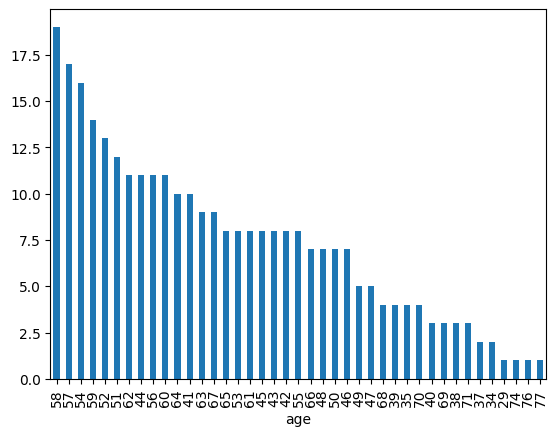

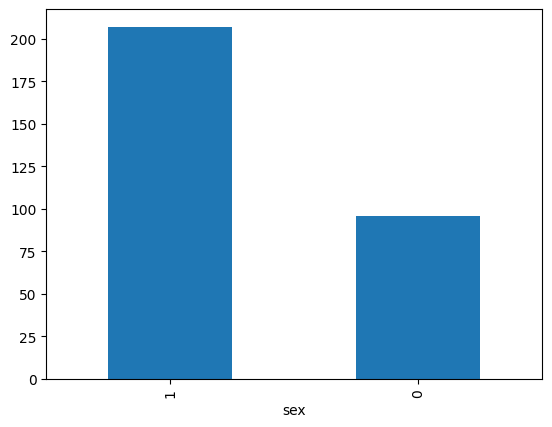

In [45]:
# your code
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("heart.csv")
df.info()
# No missing or categorical features
df['age'].value_counts().plot(kind='bar')
plt.show()
df['sex'].value_counts().plot(kind='bar')
plt.show()
# this dataset skews towards people in their fifties with sex 1 (presumably male)

### 2.2 Split the data into two subsets and normalize the features of samples

* Split the dataset into the train_val set and testing set. 
* Normalize features

In [46]:
## your code
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df.drop('target', axis=1).values
y = df['target'].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.108, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

train_val: 270, test: 33


### 2.3 Train the logistic regression model and select the hyperparameter with cross-validation

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

* Use the 10-fold cross-validation to select the hyperparameter $\lambda$.
* Search $\lambda$ from $\{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 20, 50, 100\}$


In [47]:
## your code
import numpy as np
from sklearn.linear_model import LogisticRegression
from random import shuffle
# here we use 10-fold cross-validation
folds = 10

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

print(index_of_samples)

# split the index of the train_valid set into 10 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# potential hyperparameters. 
#These hyperparameters are just used for illustration. 
#You should try more hyperparameters to get a good model.
#The hyperparameters must be nonnegative!
regularization_coefficient = [.00001, .0001, .001, .01, .1, 1, 10, 20, 50, 100]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 5-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg

[170 167 100 149 125 187 157 254  48 236  59 143 245 173  17  40 246 251
 206 133 249 177 127  97 155 216 128 182  62  46 163 161 232 181 137   9
 151 260   1 250 148 264  55 197  13 116 229 111 228  82 237  85 263 244
  37 210   4  95  57 120  35  90  42 193  19 166  77   5 233  27  54 145
 226 119 195 223  43  70  76 185 138  24 144  81 188 218 184 168 159 266
   3 189  39 115  21 101 146  68 225 252 108 135 190 124 220  53 192 114
 211 224 134  86  45 104 150 121 126  98  12  79 212 204  11 180 130 122
  56  78 215  84 131  30 132 153 242 269 265 191 158  65 213 267 179  31
  69 147 241  25 175  93 199 174   7  66   6  99  41 198 141  72 123 109
 238 234  49  18 162 219 257 136 152  26 113 221 156  47  96  20  75 165
 183 129 186 203 176  80  89 222 217   8 106  33 160 194  94 205 107  67
 139 164 268 154 230   0 202 142  32 231  73  63  28 258 140 247 248 208
  58 201  88 102 227 261 256 262 172  22  36 240  87 253 200  60  61 235
  52 209 207 255  91  10 171  34  23 178 118  29  3

### 2.4 Evaluate the learned model

* Report the prediction accuracy, recall, precision, and F1 score.

* Use the bar plot to visulaize the elements of the learned model parameter vector $\mathbf{w}$. Some elements  have larger absolute values, while the others do not. Try to explain this phenomenon. 

accuracy: 0.758, recall: 0.867, precision: 0.684, f1: 0.765,


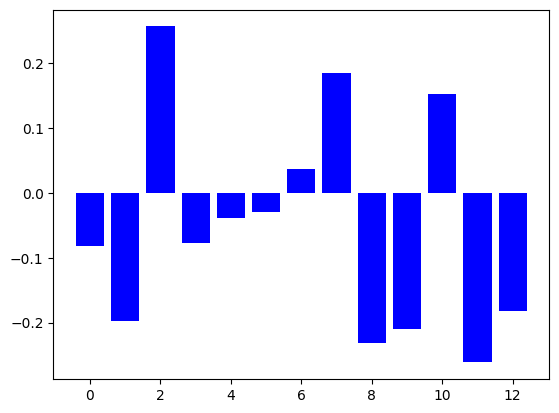

In [48]:
## your code
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# retrain the model
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

w = clf.coef_.flatten()
plt.bar(np.arange(len(w)), w, color='blue')
plt.show()

# some features have larger values as they are more important in the overall classification.
# in addition, we are using l2 regularization which will force some values closer to 0.
# some values may also be closely correlated, in which case the model may not use as big of a weight for the correlated feature.